### Lower Elwha River Dam Removal - Vegetation Changes Analysis using Python

Introduction

Location

Methods and Data

<u>Data Citations</u>


In [1]:
# Import libraries for storing and filing data
import os
import pathlib

# Import for finding map 
from osmnx import features as osm
import osmnx as ox

# Import libraries for working with raster data
import hvplot.xarray
import rioxarray as rxr
import xarray as xr

# Import library for working with dataframes
import pandas as pd

# Import library for working with geodataframes, vector data 
import geopandas as gpd

# Import library for making interactive maps and plots 
import holoviews as hv
import hvplot.pandas 

# Import for downloading data
import earthpy
import earthpy.api.appeears as eaapp

# Import library for merging polygon
from shapely.ops import unary_union

In [2]:
### Define project
project = earthpy.Project("Lower Elwha River Klallam Vegetation Change", dirname = 'lower_elwha')

In [3]:
# Search for Lower Elwha River Klallam Tribal Land
lower_elwha_gdf = ox.geocode_to_gdf('Lower Elwha Klallam Tribe')

# Call the geodataframe
lower_elwha_gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((-123.60319 48.12836, -123.5979...",-123.603192,48.100534,-123.530591,48.151398,350356005,relation,5762804,48.137795,-123.550112,boundary,aboriginal_lands,25,0.066702,aboriginal_lands,Lower Elwha Klallam Tribe,"Lower Elwha Klallam Tribe, Clallam County, Was..."


<Axes: >

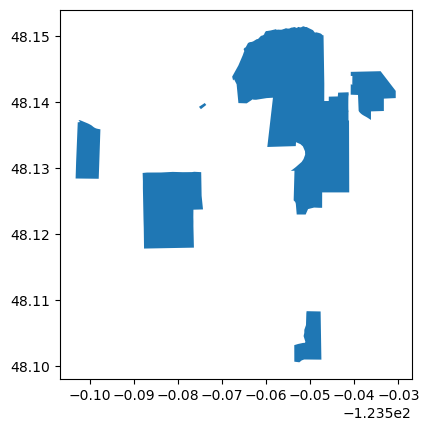

In [4]:
# Plot the polygon to check shape
lower_elwha_gdf.plot()

In [5]:
# Plot the results with web tile images
lower_elwha_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    fill_color=None, line_color='black',
    title='Lower Elwha Klallam Tribe',
    frame_width=500)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [6]:
### Initialize AppeearsDownloader for MODIS NDVI data
### Set parameters
ndvi_downloader = eaapp.AppeearsDownloader(

    ### Name download
    download_key = "lower_elwha_ndvi",

    ### Put data in project (already defined)
    project = project,

    ### Specify the MODIS product
    product = 'MOD13Q1.061',
    layer = '_250m_16_days_NDVI',

    ### Choose a start date and end date
    start_date = "06-01",
    end_date = "09-01",

    ### Recurring means you want those dates over multiple years
    recurring = True,

    ### Specify the range of years you want
    year_range = [2008, 2018],

    ### Specify the polygon you want to get NDVI data for
    polygon = lower_elwha_gdf
)

In [ ]:
# Download data
ndvi_downloader.download_files(cache=True)

No stored credentials found for urs.earthdata.nasa.gov. Please log in.


/opt/conda/lib/python3.11/site-packages/earthpy/api/auth.py:192: UserWarning: Setting credentials not supported for 'netrc' backend.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/earthpy/api/auth.py:196: UserWarning: Failed to store credentials with 'keyring': No recommended backend was available. Install a recommended 3rd party backend package; or, install the keyrings.alt package if you want to use the non-recommended backends. See https://pypi.org/project/keyring for details.
  warnings.warn(


Credentials stored using 'env' backend.


In [ ]:
# Calculate the charector number from file path
doy_start = -25
doy_end = -19

# Create empty list
ndvi_das = []

# Loop through each NDVI image
for ndvi_path in ndvi_paths:

    # Get date from file name
    doy = ndvi_path.name[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open and read dataset and .tif file
    da = rxr.open_rasterio(ndvi_path, mask_and_scale=True).squeeze()

    # Add date dimension and clean up metadata, da is image
    da = da.assign_coords({'date': date}) # Assign coordinates
    da = da.expand_dims({'date': 1}) # Remove stray values
    da.name = 'NDVI' # Name data array

    # Prepare for concatenation
    ndvi_das.append(da)

# Return length of new list
len(ndvi_das)

In [ ]:
# Combine NDVI images from all dates using xarray
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])

# Call the dataarray
ndvi_da

In [ ]:
# Call ndvi_paths to look at data
ndvi_paths 

In [ ]:
# Plot the first tif image file
rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze().plot()

In [ ]:
# Plot the last tif image file
rxr.open_rasterio(ndvi_paths[-1], mask_and_scale=True).squeeze().plot()

In [ ]:
# Create variables for each raster to create side-by-side for comparison
recent_ndvi = rxr.open_rasterio(ndvi_paths[-1], mask_and_scale=True).squeeze()
old_ndvi = rxr.open_rasterio(ndvi_paths[0], mask_and_scale=True).squeeze()

# Create and plot side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot first 2001 image on left
old_ndvi.plot(ax=axes[0], cmap=plt.cm.PiYG, vmin=-1, vmax=1)
# Add boundary from AITSN geodataframe
gric_boundary_gdf.plot(ax=axes[0], 
                  edgecolor='black', 
                  facecolor='none', # No fill
                  linewidth=1
)
# Add title
axes[0].set_title("NDVI - Gila River 2001")

# Plot most recent 2022 image on right
recent_ndvi.plot(ax=axes[1], cmap=plt.cm.PiYG, vmin=-1, vmax=1)

# Add boundary from AITSN geodataframe
gric_boundary_gdf.plot(ax=axes[1], 
                  edgecolor='black', 
                  facecolor='none', 
                  linewidth=1
)

# Add title
axes[1].set_title("NDVI - Gila River 2022")

In [ ]:
# Calculate the mean of 2001 to 2011 NDVI data
mean_ndvi_2001_2011 = ndvi_da.sel(date=slice('2001', '2011')).mean('date').NDVI

# Plot the mean to check and view the data 
mean_ndvi_2001_2011.plot()

In [ ]:
# Calculate the mean of 2012 to 2022 NDVI data
mean_ndvi_2012_2022 = ndvi_da.sel(date=slice('2012', '2022')).mean('date').NDVI

# Plot the mean to check and view the data 
mean_ndvi_2012_2022.plot()

In [ ]:
# Compute the difference in NDVI before and after the return of water rights
ndvi_diff =(
    ndvi_da
        .sel(date=slice('2012', '2022')) # Date range
            .mean('date') # Calculate mean of date
            .NDVI # Use NDVI data
    - ndvi_da
        .sel(date=slice('2001', '2011'))
            .mean('date')
            .NDVI
)

# Call the NDVI data
ndvi_diff

In [ ]:
# Plot the difference
(
   ndvi_diff
   .hvplot(
       x='x', 
       y='y',
       title='NDVI Changes at Gila River Indian Community\n(2001-2011) vs.(2012-2022)',
       cmap='PiYG', 
       geo=True)
   *
   gric_boundary_gdf.hvplot(geo=True, fill_color=None, line_color='black')
)